[View in Colaboratory](https://colab.research.google.com/github/lrasmy/MLI_LR1/blob/master/Neural_Style_Transfer.ipynb)

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 12.8MB/s 


In [0]:
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image

In [27]:
torch.__version__

'0.4.1'

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    image = Image.open(image_path).convert("RGB")# may be we need that to convert wgatever image to 3 channel instead of 4
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)

In [0]:
class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [0]:
def main(config):
    
    # Image preprocessing
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))])
    
    # Load content and style images
    # Make the style image same size as the content image
    content = load_image(config.content, transform, max_size=config.max_size)
    style = load_image(config.style, transform, shape=[content.size(2), content.size(3)])
    
    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([target], lr=config.lr, betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval()
    
    for step in range(config.total_step):
        
        # Extract multiple(5) conv feature vectors
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 
        
        # Compute total loss, backprop and optimize
        loss = content_loss + config.style_weight * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % config.log_step == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, config.total_step, content_loss.item(), style_loss.item()))

        if (step+1) % config.sample_step == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

In [0]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--content', type=str, default='png/content.png')
    parser.add_argument('--style', type=str, default='png/style.png')
    parser.add_argument('--max_size', type=int, default=400)
    parser.add_argument('--total_step', type=int, default=2000)
    parser.add_argument('--log_step', type=int, default=10)
    parser.add_argument('--sample_step', type=int, default=500)
    parser.add_argument('--style_weight', type=float, default=100)
    parser.add_argument('--lr', type=float, default=0.003)
    
    '''Uncomment the following and delete the next block if you download this notebook as a .py file and run from the command '''
    #config = parser.parse_args()
    #print(config)
    #main(config)

In [33]:
### To upload the content and style files
'''Run the cell, browse and select all the files'''
'''Other alternatives available on https://colab.research.google.com/notebooks/io.ipynb#scrollTo=vz-jH8T_Uk2c'''

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [34]:
!ls

cont1 (1).jpg  cont3.jpg	output-2000.png  style2 (1).png  style3.jpg
cont1.jpg      content.png	output-500.png	 style21.png	 style4 (1).jpg
cont2 (1).jpg  datalab		sample_data	 style2.png	 style41.png
cont2.jpg      output-1000.png	style1 (1).jpg	 style3 (1).jpg  style4.jpg
cont3 (1).jpg  output-1500.png	style1.jpg	 style31.png	 style.png


In [42]:
'''This block to is to mainly run this code using this ipython notebook, change the arguments below''' 
config = parser.parse_args(args=[])
config.content = 'cont2.jpg'
config.style = 'style2.png'
config.max_size = 400
config.total_step = 2000
config.log_step = 10
config.sample_step = 500
config.style_weight = 100
config.lr = 0.003
print(config)
main(config)

Namespace(content='cont2.jpg', log_step=10, lr=0.003, max_size=400, sample_step=500, style='style2.png', style_weight=100, total_step=2000)
Step [10/2000], Content Loss: 3.1389, Style Loss: 305.0432
Step [20/2000], Content Loss: 6.9649, Style Loss: 225.8561
Step [30/2000], Content Loss: 9.3800, Style Loss: 167.9375
Step [40/2000], Content Loss: 10.9733, Style Loss: 129.1163
Step [50/2000], Content Loss: 12.1434, Style Loss: 104.2459
Step [60/2000], Content Loss: 13.0112, Style Loss: 87.6575
Step [70/2000], Content Loss: 13.6785, Style Loss: 75.8570
Step [80/2000], Content Loss: 14.2116, Style Loss: 66.9473
Step [90/2000], Content Loss: 14.6531, Style Loss: 59.8997
Step [100/2000], Content Loss: 15.0306, Style Loss: 54.1602
Step [110/2000], Content Loss: 15.3551, Style Loss: 49.3701
Step [120/2000], Content Loss: 15.6390, Style Loss: 45.3022
Step [130/2000], Content Loss: 15.8920, Style Loss: 41.7882
Step [140/2000], Content Loss: 16.1214, Style Loss: 38.7139
Step [150/2000], Content Lo

In [43]:
!ls

cont1 (1).jpg  cont3.jpg	output-2000.png  style2 (1).png  style3.jpg
cont1.jpg      content.png	output-500.png	 style21.png	 style4 (1).jpg
cont2 (1).jpg  datalab		sample_data	 style2.png	 style41.png
cont2.jpg      output-1000.png	style1 (1).jpg	 style3 (1).jpg  style4.jpg
cont3 (1).jpg  output-1500.png	style1.jpg	 style31.png	 style.png


Input Content:


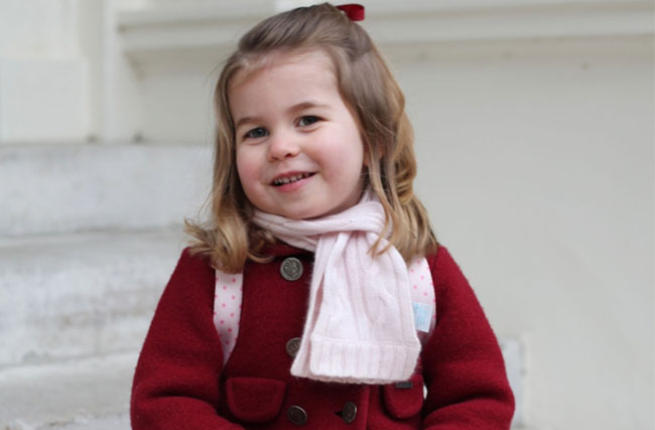

Input Style:


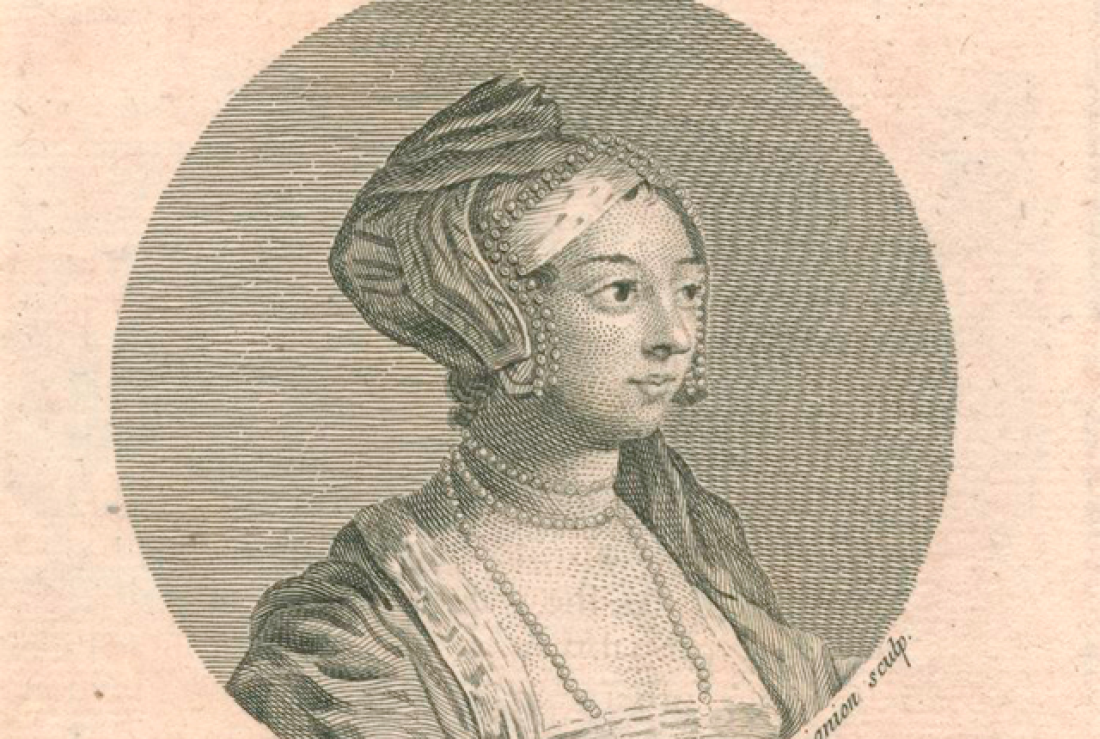

Output-500:


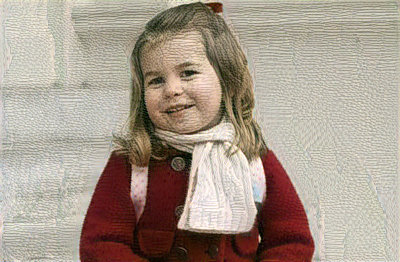

Output-1000:


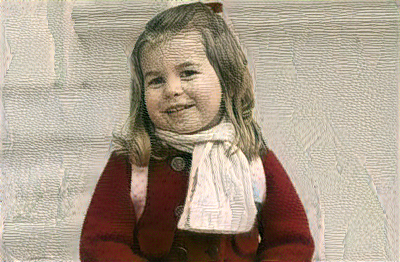

Output-1500:


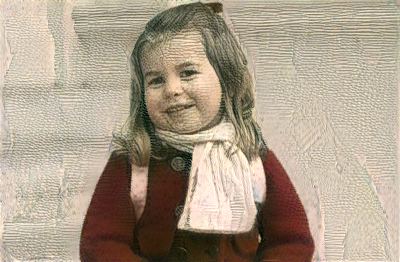

Output-2000:


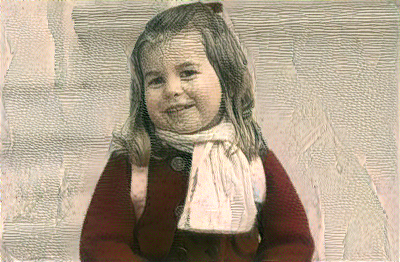

In [44]:
from IPython.display import display, Image as img
print ('Input Content:')
display(img(config.content))
print ('Input Style:')
display(img(config.style))
print ('Output-500:')
display(img('output-500.png'))
print ('Output-1000:')
display(img('output-1000.png'))
print ('Output-1500:')
display(img('output-1500.png'))
print ('Output-2000:')
display(img('output-2000.png'))

In [0]:
from google.colab import files

files.download('./output-2000.png')
